In [1]:
import pandas as pd

import glob 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import re
import yaml
import numpy as np

## Load the simulation files

- First load the csv with all the properties
- Create a dataframe for labels and scores
- Create plots for all the

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

In [3]:
plt.rcParams['axes.axisbelow'] = True

In [4]:
directories = glob.glob("toplot/*imulation_*")

In [5]:
simulation_table = pd.read_csv('Tests-list-FL r01.csv')

In [6]:
sim_id_label = list(simulation_table[(simulation_table['Simulation #'] > 20) & (simulation_table['Simulation #'] < 31) ]['Simulation #'].unique())

In [7]:
sim_id_label

[21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [8]:
def load(conf_file):
    with open(conf_file) as f:
        settings = yaml.safe_load(f)
        return settings


In [9]:
def populate_columns(df,n_clients,network_type,random_clients,n_bits,sim_n,block,frame_size,n_channels):
    df['n_clients'] = n_clients
    df['network_type'] = network_type
    df['random_clients'] = random_clients
    df['n_bits'] = n_bits
    df['sim_n'] = sim_n
    df['block'] = block
    df['frame_size'] = frame_size
    df['n_channels'] = n_channels
    return df

In [10]:
def clean_y(x):
    try: 
        l = [float(e) for e in x.replace('[tensor([[ ','').replace('tensor([[','').replace(']])','').replace(']','').replace('\n','').split(', ')]
        l_np = np.asarray(l)
        return(l_np.argmax())
    except Exception as e:
        print(e,x)

def generate_dataframe(d,score_file,event_file,sim_type,df_total,block):
    try: 
        setup = os.path.join(d,setup_file)
        settings = load(setup)
        n_clients = settings['setup']['n_clients']
        network_type = settings['setup']['network_type']
        random_clients = settings['setup']['random_clients']
        n_bits = settings['setup']['n_bits']
        fram_size = 'random'
        if 'frame_size' in settings['setup'].keys():
            frame_size = settings['setup']['frame_size']
        
        n_channels = 1
        if 'n_channels' in settings['setup'].keys():
            n_channels = settings['setup']['n_channels']

        scores = os.path.join(d,score_file)
        events = os.path.join(d,event_file)
        df_scores = pd.read_csv(scores).drop(columns=['Unnamed: 0'])
        df_events = pd.read_csv(events).drop(columns=['Unnamed: 0'])
        print("scores size: {} {}".format(d,df_scores.shape[0]))
        print("events size: {} {}".format(d,df_events.shape[0]))
        if sim_type == 'score':
            df_scores['y_values'] = df_scores['Y'].str[7:-1]
            df_scores = df_scores.astype({'y_values':float})

        elif sim_type == 'label':
            df_scores['label'] = df_scores.Y.apply(lambda x:clean_y(x))
        df_merged = pd.merge(df_scores,df_events,on='X',how='outer')
        df_merged = populate_columns(df_merged,n_clients,network_type,random_clients,n_bits,sim_n,block,fram_size,n_channels)    
        df_merged.fillna(value={'E':'run'},inplace=True)
        df_merged.fillna(method='ffill')
        print("\t**merged size: {} {}".format(d,df_merged.shape[0]))
        df_total = pd.concat([df_total,df_merged])
        return df_total
    except Exception as e:
        print(e)
        return df_total

In [11]:
df_total_label = pd.DataFrame()

setup_file = "setup_tests.yaml"
label_file = "scoreL.csv"
event_label_file = "eventL.csv"


for d in directories:
    name,sim_n = d.split('_')
    if int(sim_n) in sim_id_label:
        print('{} is a label simulation'.format(d))
        for i in range(0,5):
            block = os.path.join(d,'block_{}'.format(i))
            df_total_label = generate_dataframe(block,label_file,event_label_file,'label',df_total_label,i)
    else:
        print('problema!')
    

problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
toplot/Simulation_25 is a label simulation
scores size: toplot/Simulation_25/block_0 1600
events size: toplot/Simulation_25/block_0 405
	**merged size: toplot/Simulation_25/block_0 1905
scores size: toplot/Simulation_25/block_1 3200
events size: toplot/Simulation_25/block_1 405
	**merged size: toplot/Simulation_25/block_1 3505
scores size: toplot/Simulation_25/block_2 1600
events size: toplot/Simulation_25/block_2 405
	**merged size: toplot/Simulation_25/block_2 1905
scores size: toplot/Simulation_25/block_3 900
events size: toplot/Simulation_25/block_3 405
	**merged size: toplot/Simulation_25/block_3 1205
scores size: toplot/Simulation_25/block_4 3200
events size: toplot/Simulation_25/block_4 405
	**merged size: toplot/Simulation_25/block_4 3505
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
pro

In [12]:
df_total_label.shape

(92551, 12)

### Error rate / Channel capacity plots for label simulations

In [13]:
def clean_bits(x,init_str,n_chars):

    if x is None:
        return 0
    if x.startswith(init_str):
        return int(x[n_chars:])
    return 0
    

In [14]:
df_total_label['success'] = df_total_label.E.apply(lambda x:clean_bits(x,'Succes',26))
df_total_label['error'] = df_total_label.E.apply(lambda x:clean_bits(x,'Error',7))

In [15]:
columns_to_groupby = ['n_clients', 'network_type','random_clients', 'n_bits', 'sim_n','block']

In [16]:
gb_for_error_rate = df_total_label.groupby(columns_to_groupby,as_index=False).agg({'success': 'max', 'error': 'max'})

In [17]:
gb_for_error_rate['error_rate'] =  gb_for_error_rate['error']/(gb_for_error_rate['success'] + gb_for_error_rate['error']) 

### plot error rate bar plot 

In [18]:
gb_for_error_rate = gb_for_error_rate.astype({'sim_n':int})

In [19]:
gb_for_error_rate = gb_for_error_rate.sort_values(by=['sim_n','block'])

In [20]:
gb_for_error_rate[['sim_n']].value_counts()

sim_n
21       5
22       5
23       5
24       5
25       5
26       5
27       5
28       5
29       5
30       5
dtype: int64

In [21]:
# mpl.rc('font',family='Times New Roman')


In [21]:
gb_for_error_rate[gb_for_error_rate['sim_n'] == 22]

,n_clients,network_type,random_clients,n_bits,sim_n,block,success,error,error_rate
25,50,CNN,0.1,100,22,0,95,5,0.05
26,50,CNN,0.1,100,22,1,79,21,0.21
27,50,CNN,0.1,100,22,2,94,6,0.06
28,50,CNN,0.1,100,22,3,100,0,0.00
29,50,CNN,0.1,100,22,4,79,21,0.21


In [22]:
gb_for_error_rate.to_csv('gb_error_rate_cnn.csv',index=False)

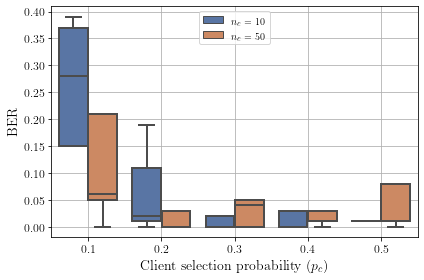

In [24]:
# font = {
#         'color': 'black',
#         'weight': 'normal',
#         'size': 12,
#         }
# sns.set_theme(style="white")
ax = sns.boxplot(x='random_clients', y='error_rate', data=gb_for_error_rate, hue='n_clients', palette=sns.color_palette('deep'), linewidth=2, showfliers=False)
# plt.title('Error rate as function of \n the probability to be selected',fontdict=font,pad=20)
plt.xlabel('Client selection probability ($p_c$)',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
handles, _ = ax.get_legend_handles_labels()          
ax.legend(handles, ['$n_c$ = 10','$n_c$ = 50'], loc="upper center")
# ,prop={'family':font['family']}
plt.grid()
plt.tight_layout()
# plt.savefig('plots/error-rate-probability_cnn.png', dpi=300)
# plt.savefig('plots/error-rate-probability_cnn.svg', dpi=300)
# plt.savefig('plots/error-rate-probability_cnn.eps', dpi=300)
# plt.savefig('plots/error-rate-probability_cnn.pdf', dpi=300)


### error rate and frame length 
 - box plot frame length

In [196]:
frame_start = df_total_label[df_total_label['E'] == 'Frame start'].copy()

In [197]:
frame_start['n_x'] =  frame_start.groupby(['sim_n','block'])['X'].shift(1)
frame_start['frame_length'] = frame_start['X'] - frame_start['n_x']  

In [198]:
frame_start.dropna(inplace=True)

In [199]:
columns_to_groupby

['n_clients', 'network_type', 'random_clients', 'n_bits', 'sim_n', 'block']

In [200]:
frame_start_dd = frame_start[columns_to_groupby+['frame_length']].drop_duplicates()

In [201]:
frame_start_dd.sim_n.value_counts()

24    5
21    5
28    5
29    5
27    5
23    5
30    5
25    5
26    5
22    5
Name: sim_n, dtype: int64

In [202]:
frame_start_dd.head()

,n_clients,network_type,random_clients,n_bits,sim_n,block,frame_length
20,10,CNN,0.3,100,25,0,16.0
36,10,CNN,0.3,100,25,1,32.0
20,10,CNN,0.3,100,25,2,16.0
13,10,CNN,0.3,100,25,3,9.0
36,10,CNN,0.3,100,25,4,32.0


In [203]:
frame_start_dd.to_csv('frame_start_dd_cnn.csv',index=False)

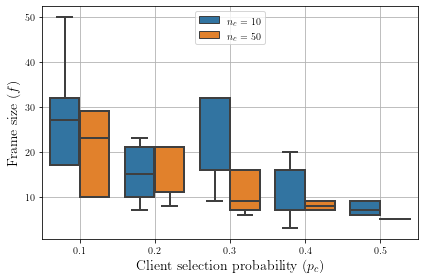

In [204]:
ax = sns.boxplot(x='random_clients', y='frame_length', data=frame_start_dd, hue='n_clients', linewidth=2, showfliers=False)
# plt.title('Error rate as function of \n the probability to be selected',fontdict=font,pad=20)
plt.xlabel('Client selection probability ($p_c$)',fontsize=14)
plt.ylabel('Frame size ($f$)',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
handles, _ = ax.get_legend_handles_labels()          
ax.legend(handles, ['$n_c$ = 10','$n_c$ = 50'], loc="upper center")
plt.grid()
plt.tight_layout()
# plt.savefig('plots/frame_length-probability_cnn.png', dpi=300)
# plt.savefig('plots/frame_length-probability_cnn.svg', dpi=300)
# plt.savefig('plots/frame_length-probability_cnn.eps', dpi=300)
# plt.savefig('plots/frame_length-probability_cnn.pdf', dpi=300)


### error rate and frame length 
 - calcolare lunghezza dei frame
 - scatter plot

## Error rate in time

In [23]:
columns_to_groupby

['n_clients', 'network_type', 'random_clients', 'n_bits', 'sim_n', 'block']

In [24]:
success = df_total_label[df_total_label.E.str.startswith('Successful Transmissions:')][['X']+columns_to_groupby+['success']]

In [25]:
errors = df_total_label[df_total_label.E.str.startswith('Errors:')][['X']+columns_to_groupby+['error']]

In [26]:
success_errors_time = pd.merge(success,errors,on=['X']+columns_to_groupby,how='inner')

success_errors_time['rate'] = success_errors_time['error']/(success_errors_time['error']+success_errors_time['success'])

In [27]:
success_errors_time.head()

,X,n_clients,network_type,random_clients,n_bits,sim_n,block,success,error,rate
0,50,10,CNN,0.3,100,25,0,1,0,0.0
1,66,10,CNN,0.3,100,25,0,2,0,0.0
2,82,10,CNN,0.3,100,25,0,3,0,0.0
3,98,10,CNN,0.3,100,25,0,4,0,0.0
4,114,10,CNN,0.3,100,25,0,5,0,0.0


In [28]:
success_errors_time[['sim_n','block']].value_counts().reset_index().sort_values(by='sim_n')

,sim_n,block,0
0,21,0,100
28,21,2,100
29,21,3,100
30,21,4,100
13,21,1,100
31,22,0,100
32,22,1,100
33,22,2,100
34,22,3,100
35,22,4,100


In [29]:
n_clients = 50
n_bits = 100

cond_gb = (success_errors_time['n_bits']==n_bits) & (success_errors_time['n_clients']==n_clients)


filtered_rate = success_errors_time[cond_gb].sort_values(by='sim_n',ascending=False)
filtered_rate = filtered_rate.astype({'sim_n':int})


In [30]:
filtered_rate.columns

Index(['X', 'n_clients', 'network_type', 'random_clients', 'n_bits', 'sim_n',
       'block', 'success', 'error', 'rate'],
      dtype='object')

In [31]:
filtered_rate = filtered_rate.sort_values(by=['sim_n','block','X'])

In [32]:
filtered_rate['counter'] = filtered_rate.groupby(['sim_n','block']).cumcount()+1


In [33]:
filtered_rate = filtered_rate.sort_values(by=['sim_n','block'])

In [34]:
filtered_rate['toplot'] = filtered_rate['error'] - filtered_rate['error'].shift() 

In [35]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
success_errors_time = success_errors_time.sort_values(by=['sim_n','block','X'])

In [37]:
success_errors_time['counter'] = success_errors_time.groupby(['sim_n','block']).cumcount()+1

In [38]:
success_errors_time = success_errors_time.sort_values(by=['sim_n','block'])

In [39]:
success_errors_time['toplot'] = success_errors_time['error'] - success_errors_time['error'].shift() 

In [47]:
def scatter_plot(filtered_rate,random_clients):

    sel = filtered_rate[(filtered_rate['toplot'] == 1) & (filtered_rate['random_clients'] == random_clients) ]
    print(sel.shape)
    regr = linear_model.LinearRegression()

    X = sel['counter']

    y = sel['error']

    regr.fit(np.array(X).reshape(-1, 1), y)

    regr.coef_

    regr.intercept_

    y_pred = regr.predict(np.array(X).reshape(-1, 1))
    y_pred_2 = regr.predict(np.arange(0,101,1).reshape(-1,1))
    
    r2_score(y,y_pred)


    ax = sns.scatterplot(data=sel, hue='n_clients', x='counter', y='error',marker='x',palette='Set1',s=50)
#     s = plt.scatter(x = sel.counter,y=sel.error,marker='x',c=sel.n_clients,cmap='viridis',label=c)
    plt.plot(np.arange(0,101,1).reshape(-1,1), y_pred_2, color='blue', linewidth=3)
    plt.ylabel('N. of Errors',fontdict=font)
    plt.xlabel('N. of bits sent',fontdict=font)
    handles, _ = ax.get_legend_handles_labels()          
    plt.legend(handles, ['N. of Clients 10','N. of Clients 50'], loc="upper center")
    
    plt.grid()
    plt.ylim((0,25))
    plt.tight_layout()
    plt.savefig('plots/error-rate-scatter_{}_hue_cnn.png'.format(random_clients), dpi=300)
    plt.savefig('plots/error-rate-scatter_{}_hue_cnn.svg'.format(random_clients), dpi=300)
    plt.savefig('plots/error-rate-scatter_{}_hue_cnn.eps'.format(random_clients), dpi=300)
    plt.savefig('plots/error-rate-scatter_{}_hue_cnn.pdf'.format(random_clients), dpi=300)

    plt.show()

In [45]:
def scatter_plot_seaborn(filtered_rate,random_clients):

    sel = filtered_rate[(filtered_rate['toplot'] == 1) & (filtered_rate['random_clients'] == random_clients) ]
    print(sel.shape)
    regr = linear_model.LinearRegression()

    X = sel['counter']

    y = sel['error']

    regr.fit(np.array(X).reshape(-1, 1), y)

    regr.coef_

    regr.intercept_

    y_pred = regr.predict(np.array(X).reshape(-1, 1))
    y_pred_2 = regr.predict(np.arange(0,101,1).reshape(-1,1))
    
    r2_score(y,y_pred)

    ax = sns.regplot(data=sel, x='counter', y='error',marker='+',scatter_kws={'s':100})

#     ax = sns.scatterplot(data=sel, hue='n_clients', x='counter', y='error',marker='x',palette='seismic',s=50)
#     s = plt.scatter(x = sel.counter,y=sel.error,marker='x',c=sel.n_clients,cmap='viridis',label=c)
#     plt.plot(np.arange(0,101,1).reshape(-1,1), y_pred_2, color='blue', linewidth=3)
    plt.ylabel('N. of Errors',fontdict=font)
    plt.xlabel('N. of bits sent',fontdict=font)
#     handles, _ = ax.get_legend_handles_labels()          
#     plt.legend(handles, ['N. of Clients 10','N. of Clients 50'], loc="upper center")
    
#     plt.legend(loc='best')
    plt.grid()
    plt.ylim((0,25))
    plt.savefig('plots/error-rate-scatter_{}_cnn.png'.format(random_clients), dpi=300)
    plt.savefig('plots/error-rate-scatter_{}_cnn.svg'.format(random_clients), dpi=300)
    plt.savefig('plots/error-rate-scatter_{}_cnn.eps'.format(random_clients), dpi=300)
    plt.savefig('plots/error-rate-scatter_{}_cnn.pdf'.format(random_clients), dpi=300)

    plt.show()

In [48]:
for i in [0.1,0.2,0.3,0.4,0.5]:
    print(i)
    scatter_plot(success_errors_time,i)

0.1
(187, 12)


NameError: name 'font' is not defined

RuntimeError: latex was not able to process the following string:
b'n_clients'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/fpinell/.cache/matplotlib/tex.cache/6b9e80fb12816c225d609a6adf7af779.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 6b9e80fb12816c225d609a6adf7af779.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily n_
                  clients}
No pages of output.
Transcript written on 6b9e80fb12816c225d609a6adf7af779.log.




<Figure size 432x288 with 1 Axes>

In [40]:
success_errors_time['tenth'] = success_errors_time['counter'] // 10

In [41]:
gb_filtered = success_errors_time.groupby(['sim_n','tenth'],as_index=False).agg({'rate':['mean','std'],
                                                                          'sim_n':'first',
                                                                          'network_type':'first',
                                                                          'random_clients':'first',
                                                   'n_bits':'first',
                                                   'n_clients':'first'})

In [42]:
gb_filtered = success_errors_time.groupby(['sim_n','tenth'],as_index=False).agg(
    mean_error = pd.NamedAgg(column='rate', aggfunc='mean'),
    std_error = pd.NamedAgg(column='rate', aggfunc='std'),
    sim_n = pd.NamedAgg(column='sim_n', aggfunc='first'),
    random_clients = pd.NamedAgg(column='random_clients', aggfunc='first'),
    network_type = pd.NamedAgg(column='network_type', aggfunc='first'),
    n_bits = pd.NamedAgg(column='n_bits', aggfunc='first'),
    n_clients = pd.NamedAgg(column='n_clients', aggfunc='first'),
)

In [43]:
gb_filtered.head()

,tenth,mean_error,std_error,sim_n,random_clients,network_type,n_bits,n_clients
0,0,0.037866,0.067090,21,0.1,CNN,100,10
1,1,0.113495,0.048579,21,0.1,CNN,100,10
2,2,0.180277,0.063166,21,0.1,CNN,100,10
3,3,0.176310,0.077495,21,0.1,CNN,100,10
4,4,0.168769,0.089252,21,0.1,CNN,100,10


In [44]:
import math

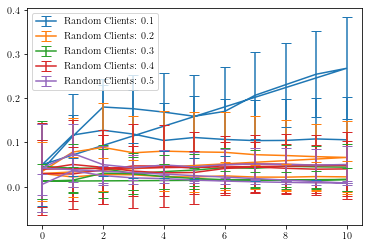

In [54]:
for x,gb in gb_filtered.groupby('random_clients'):
    plt.errorbar(gb.tenth,gb.mean_error,yerr=gb.std_error,
                 barsabove=True,
                 capsize=5,
                 label='Random Clients: {}'.format(x))
plt.legend(loc='best')
plt.show()

In [55]:
success_errors_time.sim_n.unique()

array(['21', '22', '23', '24', '25', '26', '27', '28', '29', '30'],
      dtype=object)

In [56]:
success_errors_time.n_clients.unique()

array([10, 50])

In [57]:
success_errors_time.head()

,X,n_clients,network_type,random_clients,n_bits,sim_n,block,success,error,rate,counter,toplot,tenth
3000,152,10,CNN,0.1,100,21,0,1,0,0.0,1,NaN,0
3001,202,10,CNN,0.1,100,21,0,2,0,0.0,2,0.0,0
3002,252,10,CNN,0.1,100,21,0,3,0,0.0,3,0.0,0
3003,302,10,CNN,0.1,100,21,0,4,0,0.0,4,0.0,0
3004,352,10,CNN,0.1,100,21,0,5,0,0.0,5,0.0,0


In [45]:
success_errors_time.groupby(['sim_n','n_clients'],as_index=False).agg({'rate':'mean'})

,sim_n,n_clients,rate
0,21,10,0.172182
1,22,50,0.105752
2,23,10,0.072761
3,24,50,0.023838
4,25,10,0.025432
5,26,50,0.033546
6,27,10,0.043320
7,28,50,0.039725
8,29,10,0.015974
9,30,50,0.050321


In [48]:
font = {
        'family': "Times New Roman",
        'color': 'black',
#         'weight': 'high',
#         'size': 14,
        }

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


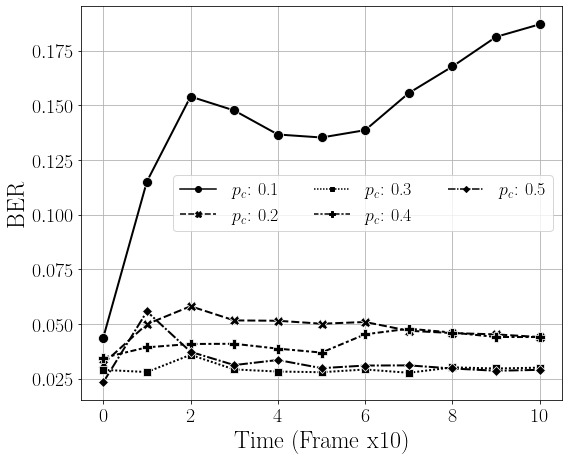

In [51]:
plt.figure(figsize=(8,6.5))

ax = sns.lineplot(data=success_errors_time,
                  x="tenth",
                  y="rate",
                  markers=True,
                  dashes=True,
                  hue='random_clients',
                  style='random_clients',
                  palette=['black']*len(success_errors_time.random_clients.unique()),
                  ci=None,
                  linewidth=2,
                markersize=10
                 )
handles, _ = ax.get_legend_handles_labels()

labels = ['$p_c$: {}'.format(v) for v in sorted(success_errors_time.random_clients.unique())]
plt.xlabel('Time (Frame x10)',fontsize=24)
plt.ylabel('BER',fontsize=24)
plt.xticks(fontsize=20,**font)
plt.yticks(fontsize=20,**font)
plt.legend(handles,labels,
           loc='center right',fontsize=18,
#            bbox_to_anchor=(0.25, 1.55),
           ncol=3)    
plt.grid()
plt.gray()
plt.tight_layout()

plt.savefig('plots/error-rate_over_time_cnn.png', dpi=300)
plt.savefig('plots/error-rate_over_time_cnn.eps', dpi=300)
plt.savefig('plots/error-rate_over_time_cnn.svg', dpi=300)
plt.savefig('plots/error-rate_over_time_cnn.pdf', dpi=300)
plt.show()

## channel capacity computation

#### Leggere i log e caricarsi la lista di bit inviati/ricevuti e per ogni simulazione, contare:
- bit = 0 inviati
- bit = 1 inviati 
- bit = 0 sbagliati
- bit = 1 sbaglati 

In [60]:
sim_n = 21

In [61]:
for sim_n in range(21,30):
    for block in range(0,5):
        file_name = 'toplot/Simulation_{}/block_{}/simulazione_{}.out'.format(sim_n,block,sim_n)
        sending = []
        receiving = []
        with open(file_name) as f:
            for l in f:
                if ('Sender: SENDING ' in l ):
                    sending.append(l.strip('\n').replace(']','')[-1:])
                elif ("Receiver: RECEIVED" in l):
                    receiving.append(l.strip('\n')[-1:])
        d = {'sent': sending, 'received': receiving[1:]}
        if len(sending) == 200:
            print(len(sending),len(receiving),sim_n,block)
# df = pd.DataFrame(data=d)


In [139]:
directories = glob.glob("toplot/*imulation_*")

In [140]:
def read_logs(df_total,file_name,setup_file,block,sim_n):
    sending = []
    receiving = []
    labels_sent = []
    labels_received = []
    with open(file_name) as f:
        for l in f:
            if ('Sender: SENDING ' in l ):
                sending.append(l.replace(']','').strip('\n')[-1:])
            elif ("Receiver: RECEIVED" in l):
                receiving.append(l.replace(']','').strip('\n')[-1:])
            elif ("Sender: frame starts with" in l):
                labels_sent.append(l.replace(']','').strip('\n')[-2:-1])
            elif ("frame ends with" in l):
                labels_received.append(l.replace(']','').strip('\n')[-2:-1])
    print(len(labels_sent),len(labels_received))
    d = {'sent': sending, 'received': receiving[1:],'label_sent':labels_sent,'label_received':labels_received[1:]}
    
    if sim_n in ["122","81"]:
        print(sim_n)
        d = {'sent': sending, 'received': receiving,'label_sent':labels_sent,'label_received':labels_received}
    
    df = pd.DataFrame(data=d)
    df['error'] = df.apply(lambda x: 1 if x.sent != x.received else 0,axis=1)
    
    settings = load(setup_file)
    n_clients = settings['setup']['n_clients']
    network_type = settings['setup']['network_type']
    random_clients = settings['setup']['random_clients']
    n_bits = settings['setup']['n_bits']
    frame_size = 'random'
    if 'frame_size' in settings['setup'].keys():
            frame_size = settings['setup']['frame_size']
        
    n_channels = 1
    if 'n_channels' in settings['setup'].keys():
        n_channels = settings['setup']['n_channels']
    df = populate_columns(df,n_clients,network_type,random_clients,n_bits,sim_n,block,frame_size,n_channels)
    
    df_total = pd.concat([df_total,df])
    return df_total

In [141]:
sim_id_label = list(simulation_table[simulation_table['Simulation #'].isin(list(range(21,31))+[81])]['Simulation #'].unique())

df_total_capacity = pd.DataFrame()

for d in sorted(directories):
    name,sim_n = d.split('_')
    if int(sim_n) in sim_id_label:
        print('{} is a label simulation'.format(d))
        log_file = "simulazione_{}.out".format(sim_n)
        setup_file = "setup_tests.yaml"
        for i in range(0,5):
#             if sim_n != '81' and i != 1:
            block_log = os.path.join(d,'block_{}'.format(i),log_file)
            block_setup_file = os.path.join(d,'block_{}'.format(i),setup_file)
            df_total_capacity = read_logs(df_total_capacity,block_log,block_setup_file,i,sim_n)
#     else:
#         print('problema!')
        

toplot/Simulation_21 is a label simulation
100 101
100 101
100 101
100 101
100 101
toplot/Simulation_22 is a label simulation
100 101
100 101
100 101
100 101
100 101
toplot/Simulation_23 is a label simulation
100 101
100 101
100 101
100 101
100 101
toplot/Simulation_24 is a label simulation
100 101
100 101
100 101
100 101
100 101
toplot/Simulation_25 is a label simulation
100 101
100 101
100 101
100 101
100 101
toplot/Simulation_26 is a label simulation
100 101
100 101
100 101
100 101
100 101
toplot/Simulation_27 is a label simulation
100 101
100 101
100 101
100 101
100 101
toplot/Simulation_28 is a label simulation
100 101
100 101
100 101
100 101
100 101
toplot/Simulation_29 is a label simulation
100 101
100 101
100 101
100 101
100 101
toplot/Simulation_30 is a label simulation
100 101
100 101
100 101
100 101
100 101
toplot/Simulation_81 is a label simulation
100 100
81
100 100
81
100 100
81
100 100
81
100 100
81


In [142]:
df_total_capacity

,sent,received,label_sent,label_received,error,n_clients,network_type,random_clients,n_bits,sim_n,block,frame_size,n_channels
0,0,0,8,8,0,10,CNN,0.1,100,21,0,random,1
1,0,0,8,8,0,10,CNN,0.1,100,21,0,random,1
2,1,1,8,3,0,10,CNN,0.1,100,21,0,random,1
3,0,0,3,3,0,10,CNN,0.1,100,21,0,random,1
4,0,0,3,3,0,10,CNN,0.1,100,21,0,random,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,3,3,0,10,CNN,0.5,100,81,4,8,1
96,1,1,3,2,0,10,CNN,0.5,100,81,4,8,1
97,0,0,2,2,0,10,CNN,0.5,100,81,4,8,1
98,1,1,2,3,0,10,CNN,0.5,100,81,4,8,1


In [143]:
df_total_capacity[df_total_capacity['sim_n'] == '21']['sent'].value_counts()

0    255
1    245
Name: sent, dtype: int64

In [144]:
df_total_capacity.label_sent.unique()

array(['8', '3', '1', '7', '5', '0', '2', '4', '9'], dtype=object)

In [145]:
frame_start = df_total_label[df_total_label['E'] == 'Frame start'].copy()

frame_start['n_x'] =  frame_start.groupby(['sim_n','block'])['X'].shift(1)
frame_start['frame_length'] = frame_start['X'] - frame_start['n_x']
frame_start.fillna(method='backfill',inplace=True)

In [146]:
frame_start['offset'] = frame_start.groupby(['sim_n','block'])['X'].transform('first')

In [147]:
frame_start['counter'] = (frame_start.X-frame_start.offset) // frame_start.frame_length 

In [148]:
frame_start_slim = frame_start[['frame_length','offset','sim_n','block']].drop_duplicates().copy()

In [149]:
df_total = pd.merge(df_total_label,frame_start_slim,on=['sim_n','block'],how='inner')

In [150]:
df_total.shape

(92551, 16)

In [151]:
df_total['counter'] = (df_total.X-df_total.offset) // df_total.frame_length 

In [152]:
df_total_capacity['counter'] = df_total_capacity.groupby(['sim_n','block']).cumcount()

In [153]:
gb_df_total = df_total.groupby(['sim_n','block','counter'],as_index=False).agg(
    score_start = pd.NamedAgg(column='Y', aggfunc='first'),
    score_end = pd.NamedAgg(column='Y', aggfunc='last'),
    counter = pd.NamedAgg(column='counter', aggfunc='first'),
    sim_n = pd.NamedAgg(column='sim_n', aggfunc='first'),
    block = pd.NamedAgg(column='block', aggfunc='first'),
    random_clients = pd.NamedAgg(column='random_clients', aggfunc='first'),
    network_type = pd.NamedAgg(column='network_type', aggfunc='first'),
    n_bits = pd.NamedAgg(column='n_bits', aggfunc='first'),
    n_clients = pd.NamedAgg(column='n_clients', aggfunc='first'),
    first_x = pd.NamedAgg(column='X', aggfunc='first'),
    last_x = pd.NamedAgg(column='X', aggfunc='last'),
    first_label = pd.NamedAgg(column='label', aggfunc='first'),
    last_label = pd.NamedAgg(column='label', aggfunc='last'),
).dropna()

In [154]:
df_merged_fs_capacity = pd.merge(gb_df_total,df_total_capacity,on=['sim_n','block','counter'],how='inner')

In [155]:
labels_sent = df_merged_fs_capacity.groupby(['sim_n','block'])['label_sent'].unique().reset_index()

In [156]:
labels_sent[labels_sent.sim_n == '30'].head()

,sim_n,block,label_sent
45,30,0,"[8, 3]"
46,30,1,"[8, 3]"
47,30,2,"[8, 3]"
48,30,3,"[2, 7]"
49,30,4,"[8, 3]"


In [157]:
def get_scores(x,labels_sent):
    
    if 'tensor' in x.score_start:
        try:
            l = [float(e.replace('[ ','').replace(']','')) for e in x.score_start.replace('tensor([[','').replace(']])','').replace('\n','').split(', ')]
            l_np = np.asarray(l)
            sel_labels = labels_sent[(labels_sent['sim_n'] == x.sim_n) & (labels_sent['block'] == x.block) ]
            for el in sorted(sel_labels['label_sent']):
                return l_np[int(el[0])],l_np[int(el[1])]
        except Exception as e:
            print(e,x.sim_n,x.score_start,labels_sent)

In [158]:
def get_scores_end(x,labels_sent):
    if 'tensor' in x.score_end:
        try: 
            l = [float(e.replace('[ ','').replace(']','')) for e in x.score_end.replace('[tensor([[ ','').replace('tensor([[','').replace(']])','').replace(']','').replace('\n','').split(', ')]
            l_np = np.asarray(l)
            sel_labels = labels_sent[(labels_sent['sim_n'] == x.sim_n) & (labels_sent['block'] == x.block) ]
            for el in sorted(sel_labels['label_sent']):
                return l_np[int(el[0])],l_np[int(el[1])]
        except Exception as e: 
            print ('Errore:', x.sim_n)

In [159]:
df_merged_fs_capacity['score_h_s'], df_merged_fs_capacity['score_l_s'] = zip(*df_merged_fs_capacity.apply(lambda x:get_scores(x,labels_sent),axis=1))

In [160]:
df_merged_fs_capacity['score_h_e'], df_merged_fs_capacity['score_l_e'] = zip(*df_merged_fs_capacity.apply(lambda x:get_scores_end(x,labels_sent),axis=1))

In [161]:
cols = ['sent','received','label_sent','label_received','error','score_h_s','score_l_s','score_h_e','score_l_e','first_label','last_label','first_x','last_x'] #+ ['score_{}'.format(i) for i in range(0,10)]

In [162]:
df_merged_fs_capacity['diff'] = df_merged_fs_capacity.score_l_e - df_merged_fs_capacity.score_h_e

In [163]:
df_merged_fs_capacity['diff_expected'] = np.sign(df_merged_fs_capacity['diff'])

In [164]:
def signal_expected(x):
    factor = 1
    if x.error == 1:
        factor = -1
    return factor*x.diff_expected

In [165]:
gb_capacity = df_merged_fs_capacity.loc[df_merged_fs_capacity.groupby(['sim_n','block'])['diff'].idxmax()]

In [166]:
gb_capacity = gb_capacity[['sim_n','block','diff']]

In [167]:
df_merged = pd.merge(df_merged_fs_capacity,gb_capacity,on=['sim_n','block'],how='left')

In [168]:
df_merged['diff_scaled'] = df_merged['diff_x'] / df_merged['diff_y']

In [169]:
df_merged_fs_capacity = df_merged.copy()

In [170]:
df_merged_fs_capacity['diff_expected'] = df_merged_fs_capacity.apply(lambda x:signal_expected(x),axis=1)

In [171]:
df_merged_fs_capacity['rumore'] = df_merged_fs_capacity['diff_scaled'] - df_merged_fs_capacity['diff_expected'] 

In [172]:
import math

In [173]:
gb_rumore = df_merged_fs_capacity.groupby('sim_n',as_index=False)['rumore'].std()

merged_rumore_std = pd.merge(df_merged_fs_capacity,gb_rumore,on='sim_n')

merged_rumore_std.columns

merged_rumore_std['snr'] = merged_rumore_std['diff_scaled']**2 / merged_rumore_std['rumore_y'].std()**2

merged_rumore_std['snr'] = merged_rumore_std['snr'].apply(lambda x:10*math.log10(x))

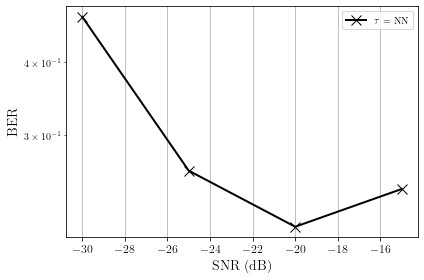

In [174]:
bins = np.arange(-30,-5,5)

labels = [b for b in bins]

merged_rumore_std['binned'] = pd.cut(merged_rumore_std['snr'], bins=bins,labels=labels[:-1])

test = merged_rumore_std.groupby(['binned'],as_index=False).agg(
    error_sum = pd.NamedAgg(column='error', aggfunc='sum'),
    bit_sent = pd.NamedAgg(column='error', aggfunc='count'))

test['error_rate'] = test['error_sum'] / test['bit_sent']
test.dropna(inplace=True)
test = test.sort_values('binned')

plt.plot(test.binned,test.error_rate,'x-',c='black',label=r'$\tau$ = NN',linewidth=2,markersize=10)
# plt.plot(test_cnn.binned,test_cnn.error_rate,'^--',c='black',label=r'$\tau$ = CNN',linewidth=2,markersize=10)
plt.xlabel('SNR (dB)',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(loc='best')
plt.yscale('log')

plt.tight_layout()

# plt.savefig('plots/snr_ber.png', dpi=300)
# plt.savefig('plots/snr_ber.eps', dpi=300)
# plt.savefig('plots/snr_ber.svg', dpi=300)
# plt.savefig('plots/snr_ber.pdf', dpi=300)
plt.show()

In [175]:
test.to_csv('snr_ber_cnn.csv')

In [176]:
df_merged_fs_capacity['snr'] = df_merged_fs_capacity['diff_scaled']**2 / df_merged_fs_capacity['rumore'].std()**2

In [177]:
df_merged_fs_capacity['snr'] = df_merged_fs_capacity['snr'].apply(lambda x:10*math.log10(x))

In [178]:
df_merged_fs_capacity = df_merged_fs_capacity[df_merged_fs_capacity.rumore != 0].copy()

In [198]:
bins = np.arange(-30,5,5)

labels = [b for b in bins]

In [199]:
df_merged_fs_capacity['binned'] = pd.cut(df_merged_fs_capacity['snr'], bins=bins,labels=labels[:-1])

In [200]:
test = df_merged_fs_capacity.groupby(['binned'],as_index=False).agg(
    error_sum = pd.NamedAgg(column='error', aggfunc='sum'),
    bit_sent = pd.NamedAgg(column='error', aggfunc='count'))

In [201]:
test['error_rate'] = test['error_sum'] / test['bit_sent']

In [202]:
test = test.sort_values('binned')

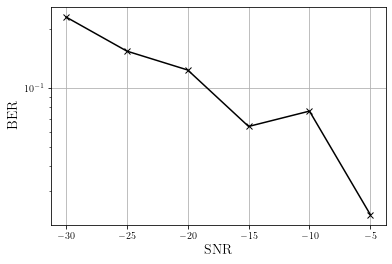

In [203]:
plt.plot(test.binned,test.error_rate,'x-',c='black')
plt.ylabel('BER',fontsize=14)
plt.xlabel('SNR',fontsize=14)
plt.grid()
plt.yscale('log')

In [204]:
test.to_csv('snr_ber_cnn.csv')

In [182]:
gb_per_bit = df_total_capacity.groupby(['sim_n','block','sent'],as_index=False).agg(
    errors = pd.NamedAgg(column='error', aggfunc='sum'),
    total_sent = pd.NamedAgg(column='sent', aggfunc='count'),
    sim_n = pd.NamedAgg(column='sim_n', aggfunc='first'),
    random_clients = pd.NamedAgg(column='random_clients', aggfunc='first'),
    network_type = pd.NamedAgg(column='network_type', aggfunc='first'),
    n_bits = pd.NamedAgg(column='n_bits', aggfunc='first'),
    n_clients = pd.NamedAgg(column='n_clients', aggfunc='first'),
)

In [183]:
gb_per_bit.head()

,block,sent,errors,total_sent,sim_n,random_clients,network_type,n_bits,n_clients
0,0,0,16,57,21,0.1,CNN,100,10
1,0,1,21,43,21,0.1,CNN,100,10
2,1,0,3,48,21,0.1,CNN,100,10
3,1,1,12,52,21,0.1,CNN,100,10
4,2,0,15,48,21,0.1,CNN,100,10


In [184]:
gb_per_bit_0 = gb_per_bit[gb_per_bit['sent'] == '0'].drop(columns=['sent']).copy()
gb_per_bit_1 = gb_per_bit[gb_per_bit['sent'] == '1'].drop(columns=['sent']).copy()

In [185]:
gb_per_bit_0.rename(columns={'total_sent':'total_sent_0','errors':'errors_0'},inplace=True)
gb_per_bit_1.rename(columns={'total_sent':'total_sent_1','errors':'errors_1'},inplace=True)

In [186]:
sim_with_error_per_bit = pd.merge(gb_per_bit_0,gb_per_bit_1,on=['block','sim_n','random_clients','network_type','n_bits','n_clients'])

In [187]:
sim_with_error_per_bit.head()

,block,errors_0,total_sent_0,sim_n,random_clients,network_type,n_bits,n_clients,errors_1,total_sent_1
0,0,16,57,21,0.1,CNN,100,10,21,43
1,1,3,48,21,0.1,CNN,100,10,12,52
2,2,15,48,21,0.1,CNN,100,10,24,52
3,3,3,48,21,0.1,CNN,100,10,12,52
4,4,7,54,21,0.1,CNN,100,10,21,46


In [188]:
def get_capacity(x):
    capacity_0 = 0.5*(x.error_rate_0 + (1- x.error_rate_0)*math.log2(1- x.error_rate_0))
    capacity_1 = 0.5*(x.error_rate_1 + (1- x.error_rate_1)*math.log2(1- x.error_rate_1))
    return 1 + capacity_0 + capacity_1

In [189]:
sim_with_error_per_bit['error_rate_0'] = sim_with_error_per_bit.errors_0 / sim_with_error_per_bit.total_sent_0 

In [190]:
sim_with_error_per_bit['error_rate_1'] = sim_with_error_per_bit.errors_1 / sim_with_error_per_bit.total_sent_1

In [191]:
sim_with_error_per_bit['error_rate_1'].mean()

0.11639882301059762

In [192]:
import math

In [193]:
sim_with_error_per_bit['capacity'] = sim_with_error_per_bit.apply(lambda x:get_capacity(x),axis=1)

In [194]:
sim_with_error_per_bit['error_rate'] = (sim_with_error_per_bit.errors_0 + sim_with_error_per_bit.errors_1)/(sim_with_error_per_bit.total_sent_0 + sim_with_error_per_bit.total_sent_1) 

In [195]:
sim_with_error_per_bit.sim_n.value_counts()

23    5
27    5
21    5
26    5
22    5
25    5
29    5
28    5
24    5
Name: sim_n, dtype: int64

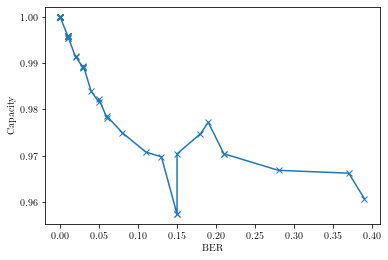

In [196]:
plt.plot(sim_with_error_per_bit.sort_values(by='error_rate',ascending=False).error_rate,sim_with_error_per_bit.sort_values(by='error_rate',ascending=False).capacity,'x-')
# plt.ylim([0,1])
plt.xlabel('BER')
plt.ylabel('Capacity')
plt.show()

No handles with labels found to put in legend.


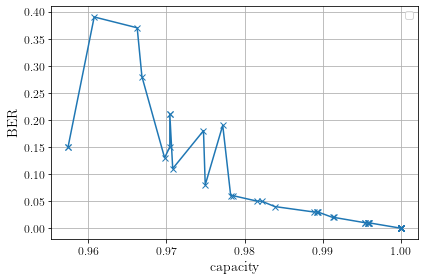

In [197]:
plt.plot(sim_with_error_per_bit.sort_values(by='capacity',ascending=False).capacity,sim_with_error_per_bit.sort_values(by='capacity',ascending=False).error_rate,'x-')
plt.xlabel('capacity',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(loc='best')
# plt.yscale('log')

plt.tight_layout()
# plt.savefig('plots/cap_ber_cnn.png', dpi=300)
# plt.savefig('plots/cap_ber_cnn.eps', dpi=300)
# plt.savefig('plots/cap_ber_cnn.svg', dpi=300)
# plt.savefig('plots/cap_ber_cnn.pdf', dpi=300)

In [198]:
gb_snr = df_merged_fs_capacity.groupby(['sim_n','block'],as_index=False).agg(
    snr_avg = pd.NamedAgg(column='snr', aggfunc='mean'),
    sim_n = pd.NamedAgg(column='sim_n', aggfunc='first'),
    block = pd.NamedAgg(column='block', aggfunc='first'),
)

KeyError: "Column 'snr' does not exist!"

In [200]:
merged_capacity_snr = pd.merge(gb_snr,sim_with_error_per_bit,on=['sim_n','block'])

In [208]:
bins = np.arange(-30,10,5)

labels = [b for b in bins]

merged_capacity_snr['binned'] = pd.cut(merged_capacity_snr['snr_avg'], bins=bins,labels=labels[:-1])

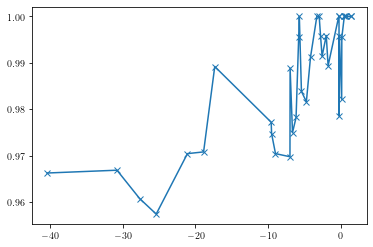

In [209]:
plt.plot(merged_capacity_snr.sort_values(by='snr_avg',ascending=False).snr_avg,merged_capacity_snr.sort_values(by='snr_avg',ascending=False).capacity,'x-')
# plt.ylim([0,1])
plt.show()

In [210]:
binned = merged_capacity_snr.groupby(['binned'],as_index=False).agg({'capacity':'mean'})

In [211]:
binned

,binned,capacity
0,-30,0.959081
1,-25,0.970430
2,-20,0.979997
3,-15,NaN
4,-10,0.981344
5,-5,0.993303
6,0,0.996803


(array([ 1.,  0.,  1.,  2.,  1.,  2.,  0.,  5., 10., 14.]),
 array([-40.4163074, -36.2266502, -32.036993 , -27.8473358, -23.6576786,
        -19.4680214, -15.2783642, -11.088707 ,  -6.8990498,  -2.7093926,
          1.4802646]),
 <BarContainer object of 10 artists>)

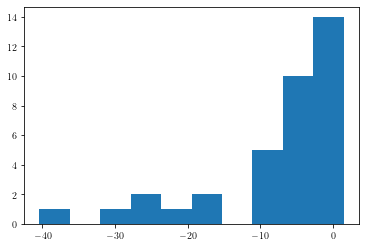

In [212]:
plt.hist(merged_capacity_snr.snr_avg)

In [214]:
binned.dropna(inplace=True)

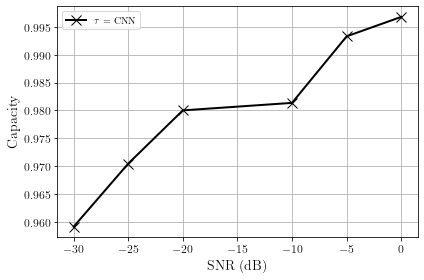

In [215]:
plt.plot(binned.binned,binned.capacity,'x-',c='black',label=r'$\tau$ = CNN',linewidth=2,markersize=10)
# plt.plot(test_cnn.binned,test_cnn.error_rate,'^--',c='black',label=r'$\tau$ = CNN',linewidth=2,markersize=10)
plt.xlabel('SNR (dB)',fontsize=14)
plt.ylabel('Capacity',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(loc='best')
# plt.yscale('log')

plt.tight_layout()

In [216]:
binned.to_csv('binned_cnn.csv',index=False)

In [206]:
def generate_dataframe(d,score_file,event_file,sim_type,df_total,block):
    try: 
        setup = os.path.join(d,setup_file)
        settings = load(setup)
        n_clients = settings['setup']['n_clients']
        network_type = settings['setup']['network_type']
        random_clients = settings['setup']['random_clients']
        n_bits = settings['setup']['n_bits']
        frame_size = 'random'
        if 'frame_size' in settings['setup'].keys():
            frame_size = settings['setup']['frame_size']
        
        n_channels = 1
        if 'n_channels' in settings['setup'].keys():
            n_channels = settings['setup']['n_channels']
        
        scores = os.path.join(d,score_file)
        events = os.path.join(d,event_file)
        df_scores = pd.read_csv(scores).drop(columns=['Unnamed: 0'])
        df_events = pd.read_csv(events).drop(columns=['Unnamed: 0'])
        print("scores size: {} {}".format(d,df_scores.shape[0]))
        print("events size: {} {}".format(d,df_events.shape[0]))
        if sim_type == 'score':
            df_scores['y_values'] = df_scores['Y'].str[7:-1]
            df_scores = df_scores.astype({'y_values':float})

#         elif sim_type == 'label':
#             df_scores['label'] = df_scores.Y.apply(lambda x:clean_y(x))
        df_merged = pd.merge(df_scores,df_events,on='X',how='outer')
        df_merged = populate_columns(df_merged,n_clients,network_type,random_clients,n_bits,sim_n,block,frame_size,n_channels)    
        df_merged.fillna(value={'E':'run'},inplace=True)
        df_merged.fillna(method='ffill')
        print("\t**merged size: {} {}".format(d,df_merged.shape[0]))
        df_total = pd.concat([df_total,df_merged])
        return df_total
    except Exception as e:
        print(e)
        return df_total

In [207]:
sim_id_label = list(simulation_table[(simulation_table['Simulation #'] > 80) & (simulation_table['Simulation #'] < 101) ]['Simulation #'].unique())

df_total_channel = pd.DataFrame()

setup_file = "setup_tests.yaml"
label_file = "scoreL.csv"
event_label_file = "eventL.csv"


for d in directories:
    name,sim_n = d.split('_')
    if int(sim_n) in sim_id_label:
        print('{} is a label simulation'.format(d))
        for i in range(0,5):
            block = os.path.join(d,'block_{}'.format(i))
            df_total_channel = generate_dataframe(block,label_file,event_label_file,'label',df_total_channel,i)
    else:
        print('problema! {}'.format(int(sim_n)))

problema! 140
problema! 74
problema! 112
problema! 126
problema! 102
toplot/Simulation_97 is a label simulation
scores size: toplot/Simulation_97/block_0 800
events size: toplot/Simulation_97/block_0 605
	**merged size: toplot/Simulation_97/block_0 1205
scores size: toplot/Simulation_97/block_1 800
events size: toplot/Simulation_97/block_1 605
	**merged size: toplot/Simulation_97/block_1 1205
scores size: toplot/Simulation_97/block_2 800
events size: toplot/Simulation_97/block_2 605
	**merged size: toplot/Simulation_97/block_2 1205
scores size: toplot/Simulation_97/block_3 800
events size: toplot/Simulation_97/block_3 605
	**merged size: toplot/Simulation_97/block_3 1205
scores size: toplot/Simulation_97/block_4 800
events size: toplot/Simulation_97/block_4 605
	**merged size: toplot/Simulation_97/block_4 1205
toplot/Simulation_96 is a label simulation
scores size: toplot/Simulation_96/block_0 800
events size: toplot/Simulation_96/block_0 605
	**merged size: toplot/Simulation_96/block_

scores size: toplot/Simulation_92/block_1 800
events size: toplot/Simulation_92/block_1 605
	**merged size: toplot/Simulation_92/block_1 1205
scores size: toplot/Simulation_92/block_2 800
events size: toplot/Simulation_92/block_2 605
	**merged size: toplot/Simulation_92/block_2 1205
scores size: toplot/Simulation_92/block_3 800
events size: toplot/Simulation_92/block_3 605
	**merged size: toplot/Simulation_92/block_3 1205
scores size: toplot/Simulation_92/block_4 800
events size: toplot/Simulation_92/block_4 605
	**merged size: toplot/Simulation_92/block_4 1205
problema! 153
problema! 23
problema! 124
problema! 66
toplot/Simulation_93 is a label simulation
scores size: toplot/Simulation_93/block_0 800
events size: toplot/Simulation_93/block_0 605
	**merged size: toplot/Simulation_93/block_0 1205
scores size: toplot/Simulation_93/block_1 800
events size: toplot/Simulation_93/block_1 605
	**merged size: toplot/Simulation_93/block_1 1205
scores size: toplot/Simulation_93/block_2 800
event

In [208]:
success = df_total_channel[(df_total_channel['E'].str.startswith('FINAL SUCCESSFUL')) ].copy()

def clean_multi(x):
    return int(x.split(': ')[1])

success['success_bits'] = success['E'].apply(lambda x: clean_multi(x))

errors = df_total_channel[(df_total_channel['E'].str.startswith('FINAL ERROR')) ].copy()

errors['errors_bits'] = errors['E'].apply(lambda x: clean_multi(x))

errors.head(1)

errors = errors[['X','errors_bits','sim_n','block']].copy()

df_error_rates = pd.merge(success,errors,on=['X','sim_n','block'])

df_error_rates = df_error_rates.sort_values(by=['sim_n','block'])

df_error_rates['error_rate'] = df_error_rates.errors_bits / (df_error_rates.errors_bits + df_error_rates.success_bits) 

In [209]:
df_error_rates.shape

(100, 14)

In [210]:
df_error_rates = df_error_rates.sort_values('sim_n')

In [211]:
df_error_rates.head()

,X,Y,E,n_clients,network_type,random_clients,n_bits,sim_n,block,frame_size,n_channels,success_bits,errors_bits,error_rate
35,802,NaN,FINAL SUCCESSFUL TRANSMISSIONS: 1471,10,CNN,0.5,100,100,0,8,20,1471,529,0.2645
36,802,NaN,FINAL SUCCESSFUL TRANSMISSIONS: 1417,10,CNN,0.5,100,100,1,8,20,1417,583,0.2915
37,802,NaN,FINAL SUCCESSFUL TRANSMISSIONS: 1390,10,CNN,0.5,100,100,2,8,20,1390,610,0.3050
38,802,NaN,FINAL SUCCESSFUL TRANSMISSIONS: 1317,10,CNN,0.5,100,100,3,8,20,1317,683,0.3415
39,802,NaN,FINAL SUCCESSFUL TRANSMISSIONS: 1417,10,CNN,0.5,100,100,4,8,20,1417,583,0.2915


In [212]:
gb_error_rates = df_error_rates.groupby('sim_n').agg(
    error_rate_mean = pd.NamedAgg(column='error_rate', aggfunc='mean'),
    sim_n = pd.NamedAgg(column='sim_n', aggfunc='first'),
    block = pd.NamedAgg(column='block', aggfunc='first'),
    random_clients = pd.NamedAgg(column='random_clients', aggfunc='first'),
    network_type = pd.NamedAgg(column='network_type', aggfunc='first'),
    n_bits = pd.NamedAgg(column='n_bits', aggfunc='first'),
    n_clients = pd.NamedAgg(column='n_clients', aggfunc='first'),
    n_channels=pd.NamedAgg(column='n_channels', aggfunc='first'))

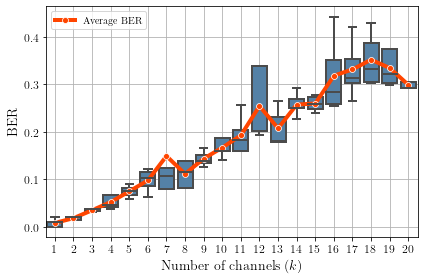

In [213]:
# font = {'family': 'times',
#         'color': 'black',
#         'weight': 'normal',
#         'size': 12,
#         }
# sns.set_theme(style="white")
ax = sns.boxplot(x='n_channels', y='error_rate', data=df_error_rates, color='steelblue', linewidth=2, showfliers=False)
sns.lineplot(x=gb_error_rates.n_channels-1,y=gb_error_rates.error_rate_mean,linewidth=4,ax=ax,color='orangered',label='Average BER',marker='o')
plt.xlabel('Number of channels ($k$)',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# handles, _ = ax.get_legend_handles_labels()          
# ax.legend(handles, ['$n_c$ = 10','$n_c$ = 50'], loc="upper center")
plt.grid()
plt.tight_layout()
# plt.savefig('plots/error-rate-probability-multi-cnn.png', dpi=300)
# plt.savefig('plots/error-rate-probability-multi-cnn.svg', dpi=300)
# plt.savefig('plots/error-rate-probability-multi-cnn.eps', dpi=300)
# plt.savefig('plots/error-rate-probability-multi-cnn.pdf', dpi=300)
plt.show()

In [214]:
df_error_rates.to_csv('error_rate_n_channels.csv',index=False)

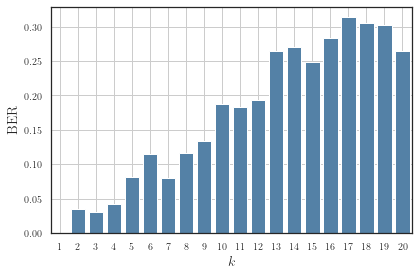

In [60]:
sns.barplot(x='n_channels',y='error_rate',data=df_error_rates,color='steelblue')
plt.xlabel('$k$',fontsize=14)
plt.ylabel('BER',fontsize=14)

# plt.legend(loc='upper left',
# #            bbox_to_anchor=(0.25, 1.55),
#            ncol=2,
#            prop={'family':font['family']})    
plt.grid()
plt.gray()
plt.tight_layout()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('plots/error-rate-probability-multi_cnn.png', dpi=300)
plt.savefig('plots/error-rate-probability-multi_cnn.eps', dpi=300)
plt.savefig('plots/error-rate-probability-multi_cnn.svg', dpi=300)
plt.savefig('plots/error-rate-probability-multi_cnn.pdf', dpi=300)
plt.show()

In [232]:
simulation_table = pd.read_csv('Tests-list-FL r01.csv')
directories = glob.glob("toplot/*imulation_*")

In [233]:
sorted(directories)

['toplot/Simulation_1',
 'toplot/Simulation_10',
 'toplot/Simulation_100',
 'toplot/Simulation_101',
 'toplot/Simulation_102',
 'toplot/Simulation_103',
 'toplot/Simulation_104',
 'toplot/Simulation_105',
 'toplot/Simulation_106',
 'toplot/Simulation_107',
 'toplot/Simulation_108',
 'toplot/Simulation_109',
 'toplot/Simulation_110',
 'toplot/Simulation_111',
 'toplot/Simulation_112',
 'toplot/Simulation_113',
 'toplot/Simulation_114',
 'toplot/Simulation_115',
 'toplot/Simulation_116',
 'toplot/Simulation_117',
 'toplot/Simulation_118',
 'toplot/Simulation_119',
 'toplot/Simulation_120',
 'toplot/Simulation_121',
 'toplot/Simulation_122',
 'toplot/Simulation_123',
 'toplot/Simulation_124',
 'toplot/Simulation_125',
 'toplot/Simulation_126',
 'toplot/Simulation_127',
 'toplot/Simulation_128',
 'toplot/Simulation_129',
 'toplot/Simulation_130',
 'toplot/Simulation_131',
 'toplot/Simulation_132',
 'toplot/Simulation_135',
 'toplot/Simulation_136',
 'toplot/Simulation_137',
 'toplot/Simula

In [234]:
sim_id_label

[135, 136, 137, 138, 139, 140, 141, 142, 143, 144]

In [13]:
sim_id_label = list(simulation_table[(simulation_table['Simulation #'] > 134) & (simulation_table['Simulation #'] < 145) ]['Simulation #'].unique())

df_total_frame = pd.DataFrame()

setup_file = "setup_tests.yaml"
label_file = "scoreL.csv"
event_label_file = "eventL.csv"


for d in directories:
    name,sim_n = d.split('_')
    if int(sim_n) in sim_id_label:
        print('{} is a label simulation'.format(d))
        for i in range(0,5):
            block = os.path.join(d,'block_{}'.format(i))
            df_total_frame = generate_dataframe(block,label_file,event_label_file,'label',df_total_frame,i)
#     else:
#         print('problema! {}'.format(int(sim_n)))

toplot/Simulation_140 is a label simulation
scores size: toplot/Simulation_140/block_0 1100
events size: toplot/Simulation_140/block_0 605
	**merged size: toplot/Simulation_140/block_0 1505
scores size: toplot/Simulation_140/block_1 1100
events size: toplot/Simulation_140/block_1 605
	**merged size: toplot/Simulation_140/block_1 1505
scores size: toplot/Simulation_140/block_2 1100
events size: toplot/Simulation_140/block_2 605
	**merged size: toplot/Simulation_140/block_2 1505
scores size: toplot/Simulation_140/block_3 1100
events size: toplot/Simulation_140/block_3 605
	**merged size: toplot/Simulation_140/block_3 1505
scores size: toplot/Simulation_140/block_4 1100
events size: toplot/Simulation_140/block_4 605
	**merged size: toplot/Simulation_140/block_4 1505
toplot/Simulation_144 is a label simulation
scores size: toplot/Simulation_144/block_0 1500
events size: toplot/Simulation_144/block_0 605
	**merged size: toplot/Simulation_144/block_0 1905
scores size: toplot/Simulation_144/b

In [14]:
df_total_frame[(df_total_frame['E'].str.startswith('FINAL ')) ].head()

success = df_total_frame[(df_total_frame['E'].str.startswith('FINAL SUCCESSFUL')) ].copy()
success['success_bits'] = success['E'].apply(lambda x: clean_multi(x))

errors = df_total_frame[(df_total_frame['E'].str.startswith('FINAL ERROR')) ].copy()

errors['errors_bits'] = errors['E'].apply(lambda x: clean_multi(x))

errors = errors[['X','errors_bits','sim_n','block']].copy()

df_error_rates = pd.merge(success,errors,on=['X','sim_n','block'])

df_error_rates = df_error_rates.sort_values(by=['sim_n','block'])

df_error_rates.head()

df_error_rates['error_rate'] = df_error_rates.errors_bits / (df_error_rates.errors_bits + df_error_rates.success_bits) 

In [15]:
df_error_rates[['sim_n','frame_size']].drop_duplicates()

,sim_n,frame_size
10,135,6
30,136,7
40,137,8
35,138,9
20,139,10
0,140,11
25,141,12
45,142,13
15,143,14
5,144,15


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


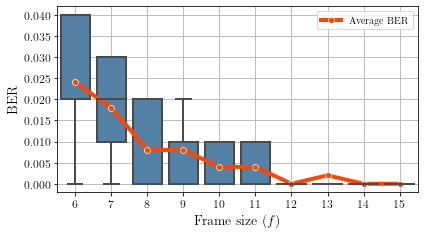

In [16]:
plt.figure(figsize=[6, 3.375])
gb_error_rates = df_error_rates.groupby('sim_n').agg(
    error_rate_mean = pd.NamedAgg(column='error_rate', aggfunc='mean'),
    sim_n = pd.NamedAgg(column='sim_n', aggfunc='first'),
    block = pd.NamedAgg(column='block', aggfunc='first'),
    random_clients = pd.NamedAgg(column='random_clients', aggfunc='first'),
    network_type = pd.NamedAgg(column='network_type', aggfunc='first'),
    n_bits = pd.NamedAgg(column='n_bits', aggfunc='first'),
    n_clients = pd.NamedAgg(column='n_clients', aggfunc='first'),
    n_channels=pd.NamedAgg(column='n_channels', aggfunc='first'),
    frame_size =pd.NamedAgg(column='frame_size', aggfunc='first')
)


ax = sns.boxplot(x='frame_size', y='error_rate', data=df_error_rates, color='steelblue', linewidth=2, showfliers=False)
sns.lineplot(x=gb_error_rates.frame_size-6,y=gb_error_rates.error_rate_mean,linewidth=4,ax=ax,color='orangered',label='Average BER',marker='o')
# plt.plot(range(6,16),gb_error_rates.error_rate_mean,linewidth=4,color='orangered',label='Average BER',marker='o')
plt.xlabel('Frame size ($f$)',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# handles, _ = ax.get_legend_handles_labels()          
# ax.legend(handles, ['$n_c$ = 10','$n_c$ = 50'], loc="upper center")
plt.grid()
plt.tight_layout()
plt.savefig('plots/error-rate-probability-frame_cnn.png', dpi=300)
plt.savefig('plots/error-rate-probability-frame_cnn.svg', dpi=300)
plt.savefig('plots/error-rate-probability-frame_cnn.eps', dpi=300)
plt.savefig('plots/error-rate-probability-frame_cnn.pdf', dpi=300)
plt.show()

In [788]:
gb_per_bit.pivot(index=['block','sim_n','random_clients','network_type','n_bits','n_clients'],columns=['sent'],values=['total_sent','errors']).reset_index()

index block sim_n random_clients network_type n_bits n_clients  \
sent                                                                  
0        0     0     1            0.1           NN    100        10   
1        1     0    10            0.5           NN    100        50   
2        2     0     2            0.1           NN    100        50   
3        3     0     3            0.2           NN    100        10   
4        4     0     4            0.2           NN    100        50   
5        5     0     5            0.3           NN    100        10   
6        6     0     6            0.3           NN    100        50   
7        7     0     7            0.4           NN    100        10   
8        8     0     8            0.4           NN    100        50   
9        9     0     9            0.5           NN    100        10   
10      10     1     1            0.1           NN    100        10   
11      11     1    10            0.5           NN    100        50   
12      12     1     2            0.1           NN    100        50   
13      13     1     3            0.2           NN    100        10   
14      14     1     4            0.2           NN    100        50   
15      15     1     5            0.3           NN    100        10   
16      16     1     6            0.3           NN    100        50   
17      17     1     7            0.4           NN    100        10   
18      18     1     8            0.4           NN    100        50   
19      19     1     9            0.5           NN    100        10   
20      20     2     1            0.1           NN    100        10   
21      21     2    10            0.5           NN    100        50   
22      22     2     2            0.1           NN    100        50   
23      23     2     3            0.2           NN    100        10   
24      24     2     4            0.2           NN    100        50   
25      25     2     5            0.3           NN    100        10   
26      26     2     6            0.3           NN    100        50   
27      27     2     7            0.4           NN    100        10   
28      28     2     8            0.4           NN    100        50   
29      29     2     9            0.5           NN    100        10   
30      30     3     1            0.1           NN    100        10   
31      31     3    10            0.5           NN    100        50   
32      32     3     2            0.1           NN    100        50   
33      33     3     3            0.2           NN    100        10   
34      34     3     4            0.2           NN    100        50   
35      35     3     5            0.3           NN    100        10   
36      36     3     6            0.3           NN    100        50   
37      37     3     7            0.4           NN    100        10   
38      38     3     8            0.4           NN    100        50   
39      39     3     9            0.5           NN    100        10   
40      40     4     1            0.1           NN    100        10   
41      41     4    10            0.5           NN    100        50   
42      42     4     2            0.1           NN    100        50   
43      43     4     3            0.2           NN    100        10   
44      44     4     4            0.2           NN    100        50   
45      45     4     5            0.3           NN    100        10   
46      46     4     6            0.3           NN    100        50   
47      47     4     7            0.4           NN    100        10   
48      48     4     8            0.4           NN    100        50   
49      49     4     9            0.5           NN    100        10   

     total_sent     errors      
sent          0   1      0   1  
0            51  49      4   6  
1            56  44      0   0  
2            54  46      0   0  
3            46  54      3   4  
4            57  43      0   4  
5            47  53      0   8  
6            54  46      0   1  
7            53

In [773]:
gb_per_bit[gb_per_bit['sent'] == '1'].total_sent.sum()

2524

In [733]:
df.error.sum()

10

In [734]:
gb_for_error_rate[gb_for_error_rate['sim_n'] == 1 ]

,n_clients,network_type,random_clients,n_bits,sim_n,block,success,error,error_rate
0,10,NN,0.1,100,1,0,90,10,0.10
1,10,NN,0.1,100,1,1,97,3,0.03
2,10,NN,0.1,100,1,2,89,11,0.11
3,10,NN,0.1,100,1,3,84,16,0.16
4,10,NN,0.1,100,1,4,87,13,0.13


In [12]:
def clean_bits(x,init_str,n_chars):

    if x is None:
        return 0
    if x.startswith(init_str):
        return int(x[n_chars:])
    return 0
    

In [11]:
def clean_y(x):
    try: 
        l = [float(e) for e in x.replace('[tensor([[','').replace('tensor([[','').replace(']])','').replace(']','').replace('\n','').split(', ')]
        l_np = np.asarray(l)
        return(l_np.argmax())
    except Exception as e:
        print('clean y',e,x)

def generate_dataframe(d,score_file,event_file,sim_type,df_total,block):
    try: 
        setup = os.path.join(d,setup_file)
        settings = load(setup)
        n_clients = settings['setup']['n_clients']
        network_type = settings['setup']['network_type']
        random_clients = settings['setup']['random_clients']
        n_bits = settings['setup']['n_bits']
        frame_size = 'random'
        if 'frame_size' in settings['setup'].keys():
            frame_size = settings['setup']['frame_size']
        
        n_channels = 1
        if 'n_channels' in settings['setup'].keys():
            n_channels = settings['setup']['n_channels']

        pattern = 'random'
        if 'patter' in settings['setup'].keys():
            pattern = settings['setup']['patter']
            
        scores = os.path.join(d,score_file)
        events = os.path.join(d,event_file)
        df_scores = pd.read_csv(scores).drop(columns=['Unnamed: 0'])
        df_events = pd.read_csv(events).drop(columns=['Unnamed: 0'])
        print("scores size: {} {}".format(d,df_scores.shape[0]))
        print("events size: {} {}".format(d,df_events.shape[0]))
        if sim_type == 'score':
            df_scores['y_values'] = df_scores['Y'].str[7:-1]
            df_scores = df_scores.astype({'y_values':float})

        elif sim_type == 'label':
            df_scores['label'] = df_scores.Y.apply(lambda x:clean_y(x))
        df_merged = pd.merge(df_scores,df_events,on='X',how='outer')
        df_merged = populate_columns(df_merged,n_clients,network_type,random_clients,n_bits,sim_n,block,frame_size,n_channels)    
        df_merged['pattern'] = pattern
        df_merged.fillna(value={'E':'run'},inplace=True)
        df_merged.fillna(method='ffill')
        print("\t**merged size: {} {}".format(d,df_merged.shape[0]))
        df_total = pd.concat([df_total,df_merged])
        return df_total
    except Exception as e:
        print('generate data frame',e)
        return df_total

### Pattern in the bit stream


In [39]:
sim_id_label = range(149,154)

setup_file = "setup_tests.yaml"
label_file = "scoreL.csv"
event_label_file = "eventL.csv"


df_total_patterns = pd.DataFrame()

for d in directories:
    name,sim_n = d.split('_')
    if int(sim_n) in sim_id_label:
        print('{} is a label simulation'.format(d))
        for i in range(0,5):
            block = os.path.join(d,'block_{}'.format(i))
            df_total_patterns = generate_dataframe(block,label_file,event_label_file,'label',df_total_patterns,i)
#     else:
#         print('problema!')
        

toplot/Simulation_150 is a label simulation
scores size: toplot/Simulation_150/block_0 1200
events size: toplot/Simulation_150/block_0 605
	**merged size: toplot/Simulation_150/block_0 1605
scores size: toplot/Simulation_150/block_1 1200
events size: toplot/Simulation_150/block_1 605
	**merged size: toplot/Simulation_150/block_1 1605
scores size: toplot/Simulation_150/block_2 1200
events size: toplot/Simulation_150/block_2 605
	**merged size: toplot/Simulation_150/block_2 1605
scores size: toplot/Simulation_150/block_3 1200
events size: toplot/Simulation_150/block_3 605
	**merged size: toplot/Simulation_150/block_3 1605
scores size: toplot/Simulation_150/block_4 1200
events size: toplot/Simulation_150/block_4 605
	**merged size: toplot/Simulation_150/block_4 1605
toplot/Simulation_153 is a label simulation
scores size: toplot/Simulation_153/block_0 1200
events size: toplot/Simulation_153/block_0 605
	**merged size: toplot/Simulation_153/block_0 1605
scores size: toplot/Simulation_153/b

In [10]:
def clean_multi(x):
    return int(x.split(': ')[1])


In [59]:
df_total_patterns[(df_total_patterns['E'].str.startswith('FINAL ')) ].head()

success = df_total_patterns[(df_total_patterns['E'].str.startswith('FINAL SUCCESSFUL')) ].copy()
success['success_bits'] = success['E'].apply(lambda x: clean_multi(x))

errors = df_total_patterns[(df_total_patterns['E'].str.startswith('FINAL ERROR')) ].copy()

errors['errors_bits'] = errors['E'].apply(lambda x: clean_multi(x))

errors = errors[['X','errors_bits','sim_n','block']].copy()

df_error_rates = pd.merge(success,errors,on=['X','sim_n','block'])

df_error_rates = df_error_rates.sort_values(by=['sim_n','block'])

df_error_rates.head()

df_error_rates['error_rate'] = df_error_rates.errors_bits / (df_error_rates.errors_bits + df_error_rates.success_bits) 

In [60]:
gb_for_error_rate.pattern.unique()

array(['0', '00001111', '01', '1', 'random'], dtype=object)

In [54]:
convert_pattern = {'0':'00','random':'Random','00001111':'55','01':'0F','1':'FF'}

In [62]:
df_error_rates['pattern_plot'] = df_error_rates.pattern.apply(lambda x:convert_pattern[x])

In [63]:
df_error_rates.to_csv('patterns_ber_cnn.csv',index=False)

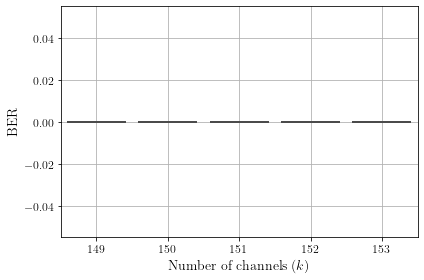

In [44]:

ax = sns.boxplot(x='sim_n', y='error_rate', data=gb_for_error_rate, color='steelblue', linewidth=2, showfliers=False)
# sns.lineplot(x=list(range(gb_error_rates.shape[0])),y=gb_error_rates.error_rate_mean,linewidth=4,ax=ax,color='orangered',label='Average BER',marker='o')
plt.xlabel('Number of channels ($k$)',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# handles, _ = ax.get_legend_handles_labels()          
# ax.legend(handles, ['$n_c$ = 10','$n_c$ = 50'], loc="upper center")
plt.grid()
plt.tight_layout()
# plt.savefig('plots/error-rate-patterns.png', dpi=300)
# plt.savefig('plots/error-rate-patterns.svg', dpi=300)
# plt.savefig('plots/error-rate-patterns.eps', dpi=300)
# plt.savefig('plots/error-rate-patterns.pdf', dpi=300)
plt.show()

## Error rate in time for score attack


In [510]:
success = df_total_score[df_total_score.E.str.startswith('Successful Transmissions:')][['X']+columns_to_groupby+['success']]

In [511]:
errors = df_total_score[df_total_score.E.str.startswith('Errors:')][['X']+columns_to_groupby+['error']]

In [512]:
success_errors_time = pd.merge(success,errors,on=['X']+columns_to_groupby,how='inner')

success_errors_time['rate'] = success_errors_time['error']/(success_errors_time['error']+success_errors_time['success'])

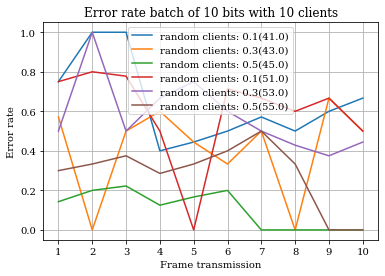

In [516]:
n_clients = 10
n_bits = 10

cond_gb = (success_errors_time['n_bits']==n_bits) & (success_errors_time['n_clients']==n_clients)

filtered_rate = success_errors_time[cond_gb].sort_values(by='sim_n',ascending=False)
filtered_rate = filtered_rate.astype({'sim_n':float})
filtered_rate.sort_values('sim_n')
for key, grp in filtered_rate.groupby(['sim_n']):
    
    label = 'random clients: {}({})'.format(grp.random_clients.iloc[0],grp.sim_n.iloc[0])
    groups = n_bits // 10
    bit_group = grp.groupby(np.arange(len(grp))//groups).agg(lambda x: {'success': x.success.sum(), 
                                                 'error': x.error.sum(),
                                                  'sim_n':x.sim_n.iloc[0],
                                                  'network_type':x.network_type.iloc[0],
                                                   'random_clients':x.random_clients.iloc[0],
                                                   'n_bits':x.n_bits.iloc[0],
                                                   'n_clients':x.n_clients.iloc[0]
                                                  })
    bit_group['rate'] = bit_group.error / (bit_group.success + bit_group.error) 
    plt.plot(range(len(bit_group)), bit_group.rate, label=label)
plt.title('Error rate batch of 10 bits with {} clients'.format(n_clients) )
plt.xticks(range(0,10),range(1,11))
plt.legend(loc='best')
plt.xlabel('Frame transmission')
plt.ylabel('Error rate')
plt.grid()
plt.show()

## count the number of error for 0 / 1

In [350]:
frames = df_total_label[df_total_label['E']=='Frame start'].copy()

In [388]:
frames['prev_label'] = frames.groupby('sim_n')['label'].shift(1)

In [393]:
frames[frames.sim_n == '5'].shape

(100, 12)

In [394]:
def get_bit(x):
    if x.label == x.prev_label:
        return 0
    else:
        return 1

In [395]:
frames['bit_sent'] = frames.apply(lambda x: get_bit(x),axis=1)

In [396]:
frames.head()

,X,Y,label,E,n_clients,network_type,random_clients,n_bits,sim_n,success,error,prev_label,bit_sent
1,44,"tensor([[ -2.5534, -3.8009, -4.3930, 20.628...",8.0,Frame start,10,NN,0.3,100,5,0,0,NaN,1
25,65,"tensor([[ -2.3878, 0.1839, -8.0644, 18.086...",3.0,Frame start,10,NN,0.3,100,5,0,0,8.0,1
49,86,"tensor([[ -2.5296, 0.2453, -7.5033, 17.867...",3.0,Frame start,10,NN,0.3,100,5,0,0,3.0,0
73,107,"tensor([[ -2.5355, 0.9111, -8.4030, 16.320...",3.0,Frame start,10,NN,0.3,100,5,0,0,3.0,0
97,128,"tensor([[ -2.6219, 0.7924, -8.7215, 17.119...",3.0,Frame start,10,NN,0.3,100,5,0,0,3.0,0


In [399]:
_test = pd.merge(df_total_label,frames[['sim_n','X','bit_sent']],on=['sim_n','X'],how='left')

In [418]:
errors = _test[_test['E'].str.contains('Errors:')][['n_clients','network_type','random_clients','n_bits','sim_n','error','bit_sent']]

In [420]:
errors['previous_error'] = errors.groupby('sim_n')['error'].shift(1)

In [425]:
errors[(errors.error - errors.previous_error)>0].bit_sent.value_counts()

0.0    44
1.0     8
Name: bit_sent, dtype: int64

In [400]:
_test.to_csv('test.csv',index=False)

### plot label transmission

In [401]:
settings = load('../label_test/Simulation_46/setup_tests.yaml')

In [402]:
n_clients = settings['setup']['n_clients']
network_type = settings['setup']['network_type']
random_clients = settings['setup']['random_clients']
n_bits = settings['setup']['n_bits']

df_scores = pd.read_csv('../label_test/Simulation_46/scoreL.csv').drop(columns=['Unnamed: 0'])
df_events = pd.read_csv('../label_test/Simulation_46/eventL.csv').drop(columns=['Unnamed: 0'])
print("scores size: {} {}".format(d,df_scores.shape[0]))
print("events size: {} {}".format(d,df_events.shape[0]))
df_merged = pd.merge(df_scores,df_events,on='X',how='outer')

df_merged = populate_columns(df_merged,n_clients,network_type,random_clients,n_bits,sim_n)


scores size: Simulation_55 430
events size: Simulation_55 45


In [403]:
import numpy as np

In [404]:
def clean_y(x):
    print(x)
    l = [float(e) for e in x.replace('tensor([[','').replace(']])','').replace('\n','').split(', ')]
    l_np = np.asarray(l)
    return(l_np.argmax())

In [405]:
df_merged.fillna(value={'E':'run'},inplace=True)

In [406]:
df_merged.fillna(method='ffill',inplace=True)

In [407]:
df_merged = df_merged.sort_values(by='X')

In [408]:
df_merged.head()

,X,Y,E,n_clients,network_type,random_clients,n_bits,sim_n
458,2,"tensor([[-0.2476, -1.0197, -1.4544, 10.7247, -...",Receiver added,10,NN,0.1,10,55
0,88,"tensor([[ -2.6168, -3.7392, -5.0046, 20.414...",Sender added,10,NN,0.1,10,55
1,88,"tensor([[ -2.6168, -3.7392, -5.0046, 20.414...",Frame start,10,NN,0.1,10,55
2,89,"tensor([[ -2.8459, -3.6503, -4.8449, 20.647...",run,10,NN,0.1,10,55
3,90,"tensor([[ -3.2668, -3.2003, -4.6614, 21.257...",run,10,NN,0.1,10,55


In [409]:
df_merged['label'] = df_merged.Y.apply(lambda x:clean_y(x))

tensor([[-0.2476, -1.0197, -1.4544, 10.7247, -7.2667, -9.3813, -4.9705,  2.8151,
         13.8809, -3.2011]])
tensor([[ -2.6168,  -3.7392,  -5.0046,  20.4145, -10.9762,  -1.8441, -14.5304,
         -16.3034,  24.2172,  10.8751]])
tensor([[ -2.6168,  -3.7392,  -5.0046,  20.4145, -10.9762,  -1.8441, -14.5304,
         -16.3034,  24.2172,  10.8751]])
tensor([[ -2.8459,  -3.6503,  -4.8449,  20.6478, -10.7497,  -1.9513, -14.6445,
         -16.2913,  24.1501,  10.6700]])
tensor([[ -3.2668,  -3.2003,  -4.6614,  21.2578, -11.0704,  -1.8599, -14.7144,
         -16.2671,  24.0593,  10.2406]])
tensor([[ -3.1273,  -3.4446,  -4.0442,  21.4171, -11.2315,  -2.1156, -15.0987,
         -16.4170,  24.0455,  10.5139]])
tensor([[ -3.0076,  -3.6575,  -4.4109,  21.0476, -10.8071,  -2.2050, -14.9272,
         -16.3061,  24.1001,  10.6549]])
tensor([[ -3.0872,  -3.5115,  -4.0418,  21.3579, -11.0425,  -2.2399, -15.1053,
         -16.4758,  24.0208,  10.6133]])
tensor([[ -3.1749,  -3.7327,  -4.3673,  21.3080, -

In [410]:
frames = df_merged[df_merged['E']=='Frame start'].copy()

In [411]:
frames['text'] = frames.label == frames.label.shift(1)

In [413]:
frames.shape

(10, 10)

In [166]:
frames['position'] = (frames.X + frames.X.shift(1))/2

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


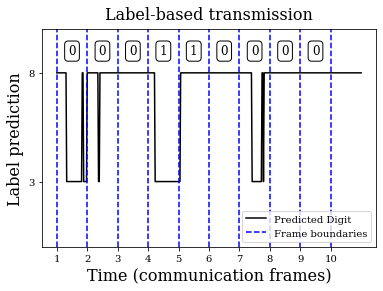

In [192]:

plt.plot(df_merged.iloc[1:,:].X,df_merged.iloc[1:,:]['label'],c='black',label='Predicted Digit')


plt.axvline(x=frames.X.iloc[0],ls='dashed',color='b',label='Frame boundaries')

for i,row in frames.iloc[1:,:].iterrows():
    plt.axvline(x=row.X,ls='dashed',color='b')
    

for i,row in frames.iterrows():
    text = '1'
    if row.text:
        text = '0'
    plt.text(row.position,9,text,family='serif',fontsize=12,ha="center", va="center",bbox=dict(boxstyle="round",fc='white'))


plt.xticks(frames.X,range(1,11),fontname='serif')
plt.yticks([3,8],[3,8],fontname='serif')
plt.ylim((0,10))
plt.title('Label-based transmission',fontdict=font,pad=10)
plt.xlabel('Time (communication frames)',fontdict=font)
plt.ylabel('Label prediction',fontdict=font)
plt.legend(loc ='lower right')
plt.savefig('label-based-transmission.png', dpi=300)
plt.savefig('label-based-transmission.svg', dpi=300)
plt.savefig('label-based-transmission.eps', dpi=300)
plt.savefig('label-based-transmission.pdf', dpi=300)

plt.show()

In [146]:
distinct.head(30)

,X,label
458,2,8
0,88,8
2,89,8
3,90,8
4,91,8
5,92,8
6,93,8
7,94,8
8,95,8
9,96,8


In [125]:
distinct.to_csv('test_label.csv',index=False)

In [ ]:
"[tensor([[ 31.1119, -16.9927,  17.3001,  -6.4038, -13.3217, -30.8231, -12.9282,           -1.3857,  33.7056,  -2.9498]])]"


In [33]:
s = "tensor([[-14.9120, -21.5085,  10.7437,  43.1620, -37.1642,   6.3763, -23.4431,\n-21.6052,  45.6571,  12.2706]])"

In [34]:
import re 


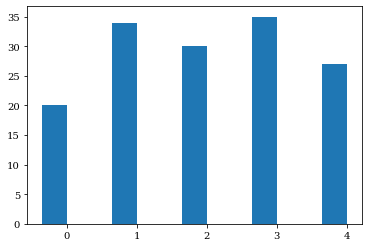

In [279]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 =  plt.bar(x - width/2, men_means, width, label='Men')
